In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchinfo import summary
import re
import random

In [2]:
sentiment_dataset = pd.read_csv("Sentiment140_filtered.csv")

In [3]:
sentiment_dataset.head()

,Unnamed: 0,target,ids,date,flag,user,text,hate_pred
0,750,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,NO_QUERY,Young_J,I'm off too bed. I gotta wake up hella early t...,1
1,766711,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,NO_QUERY,dougnawoschik,I havent been able to listen to it yet My spe...,1
2,285055,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,NO_QUERY,thireven,now remembers why solving a relatively big equ...,1
3,705995,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,taracollins086,"Ate too much, feel sick",1
4,379611,0,2052381070,Sat Jun 06 00:32:23 PDT 2009,NO_QUERY,Portablemonkey,Tried to purchase a parked domain through GoDa...,1


In [4]:
sentiment_dataset.isnull().sum()

Unnamed: 0    0
target        0
ids           0
date          0
flag          0
user          0
text          0
hate_pred     0
dtype: int64

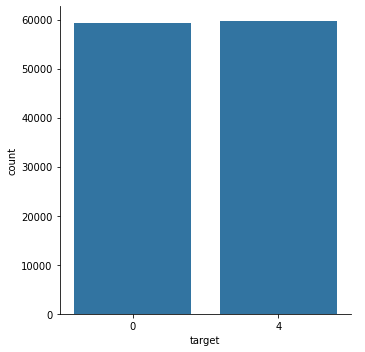

In [5]:
sns.catplot(x = 'target', data = sentiment_dataset, kind = 'count')


In [6]:
hateful_dataset = pd.read_csv("hateful_sentiment.csv")

In [7]:
hateful_dataset.head()

,Content,Label,Content_int
0,retweet to the rejects who constantly call my ...,1,"[146715, 1761, 7, 3, 22587, 67, 6768, 472, 129..."
1,i purpose that whatever attack everyone who ca...,1,"[146715, 80, 4226, 28, 220, 1347, 1568, 67, 65..."
2,are you fucking kidding me you deserve to fuck...,1,"[146715, 154, 26, 69, 1361, 78, 26, 6610, 7, 6..."
3,retweet i am not racist and i am not sexist i ...,1,"[146715, 1761, 80, 81, 76, 1723, 111, 80, 81, ..."
4,just imagine if the two million spent on the s...,1,"[146715, 14, 925, 204, 3, 672, 462, 5271, 9, 3..."


In [8]:
hateful_dataset = hateful_dataset[["Content", "Label"]]
hateful_dataset = hateful_dataset.rename(columns = {"Content": "text", "Label": "target"})
hateful_dataset["target"] = 2

hateful_dataset.head()

,text,target
0,retweet to the rejects who constantly call my ...,2
1,i purpose that whatever attack everyone who ca...,2
2,are you fucking kidding me you deserve to fuck...,2
3,retweet i am not racist and i am not sexist i ...,2
4,just imagine if the two million spent on the s...,2


In [9]:
sentiment_dataset = sentiment_dataset[["text", "target"]]
sentiment_dataset.head()

,text,target
0,I'm off too bed. I gotta wake up hella early t...,0
1,I havent been able to listen to it yet My spe...,0
2,now remembers why solving a relatively big equ...,0
3,"Ate too much, feel sick",0
4,Tried to purchase a parked domain through GoDa...,0


In [10]:
sentiment_dataset.loc[sentiment_dataset['target']==4, 'target'] = 1
sentiment_dataset.loc[sentiment_dataset['target']==0, 'target'] = 0
# 0 - negative, 1 - positive, 2 - hateful

In [11]:
sentiment_dataset = pd.concat([sentiment_dataset, hateful_dataset], ignore_index= True)

In [12]:
sentiment_dataset.head()

,text,target
0,I'm off too bed. I gotta wake up hella early t...,0
1,I havent been able to listen to it yet My spe...,0
2,now remembers why solving a relatively big equ...,0
3,"Ate too much, feel sick",0
4,Tried to purchase a parked domain through GoDa...,0


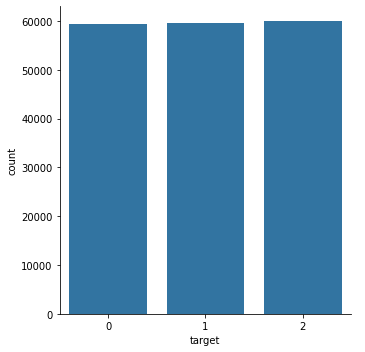

In [13]:
sns.catplot(x = 'target', data = sentiment_dataset, kind = 'count')

In [14]:
sentiment_dataset['target'].value_counts()

target
2    60000
1    59700
0    59300
Name: count, dtype: int64

In [15]:
sentiment_dataset.isnull().sum()

text      0
target    0
dtype: int64

In [16]:
X = sentiment_dataset['text']
y = sentiment_dataset['target']

In [18]:
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

CNN

In [19]:
# Tokenizacja i czyszczenie tekstu
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.split()

# Tworzenie słownika
all_tokens = [token for text in sentiment_dataset['text'] for token in tokenize(text)]
vocab = {word: i+2 for i, (word, _) in enumerate(Counter(all_tokens).most_common(10000))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def encode(text):
    return [vocab.get(token, 1) for token in tokenize(text)]

In [20]:
# Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor(encode(text)) for text in texts]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Funkcja padding collate
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    return texts_padded, torch.tensor(labels)

In [34]:
# Model CNN
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.conv1 = nn.Conv1d(embed_dim, 100, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(100, num_classes)

    def forward(self, x):
        x = self.embedding(x) 
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.dropout(x) 
        x = self.pool(x).squeeze(2)
        return self.fc(x)
    

In [35]:
# Hiperparametry
epochs_num = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextCNN(vocab_size=len(vocab), embed_dim=100, num_classes=3).to(device)
learning_rate = 1e-3
batch = 32

In [36]:
# Podsumowanie modelu
summary(model, input_size=(32, 100), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
TextCNN                                  [32, 3]                   --
├─Embedding: 1-1                         [32, 100, 100]            1,000,200
├─Conv1d: 1-2                            [32, 100, 98]             30,100
├─ReLU: 1-3                              [32, 100, 98]             --
├─Dropout: 1-4                           [32, 100, 98]             --
├─AdaptiveMaxPool1d: 1-5                 [32, 100, 1]              --
├─Linear: 1-6                            [32, 3]                   303
Total params: 1,030,603
Trainable params: 1,030,603
Non-trainable params: 0
Total mult-adds (M): 126.41
Input size (MB): 0.03
Forward/backward pass size (MB): 5.07
Params size (MB): 4.12
Estimated Total Size (MB): 9.22

In [37]:
# Podział na 5 foldów
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

def evaluate_model(model, val_loader):
    model.eval()  # Ustawienie modelu w tryb ewaluacji
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():  # Bez obliczania gradientów
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
    
    return true_labels, pred_labels

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs_num):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_acc = correct_preds / total_preds
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_acc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history



Training fold 1/5...
Epoch 1/4 - Train Loss: 0.5643 - Val Loss: 0.4800 - Train Acc: 0.7400 - Val Acc: 0.8013
Epoch 2/4 - Train Loss: 0.4244 - Val Loss: 0.4299 - Train Acc: 0.8121 - Val Acc: 0.8250
Epoch 3/4 - Train Loss: 0.3876 - Val Loss: 0.4325 - Train Acc: 0.8310 - Val Acc: 0.8136
Epoch 4/4 - Train Loss: 0.3681 - Val Loss: 0.4031 - Train Acc: 0.8396 - Val Acc: 0.8315


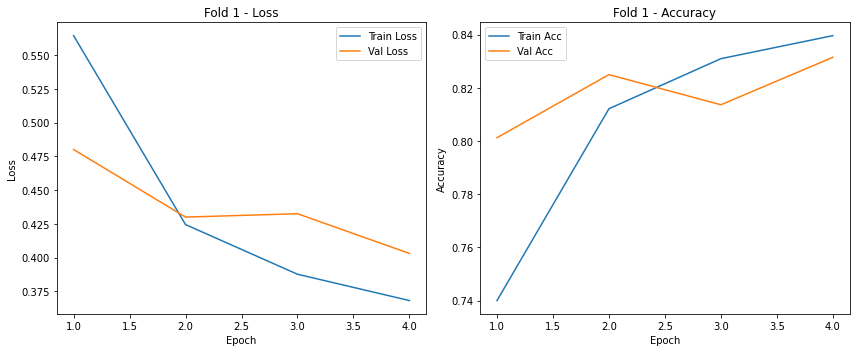

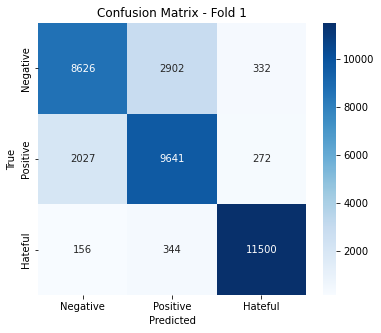


Training fold 2/5...
Epoch 1/4 - Train Loss: 0.5627 - Val Loss: 0.4731 - Train Acc: 0.7413 - Val Acc: 0.8037
Epoch 2/4 - Train Loss: 0.4239 - Val Loss: 0.4315 - Train Acc: 0.8127 - Val Acc: 0.8204
Epoch 3/4 - Train Loss: 0.3869 - Val Loss: 0.4301 - Train Acc: 0.8302 - Val Acc: 0.8083
Epoch 4/4 - Train Loss: 0.3675 - Val Loss: 0.4041 - Train Acc: 0.8406 - Val Acc: 0.8284


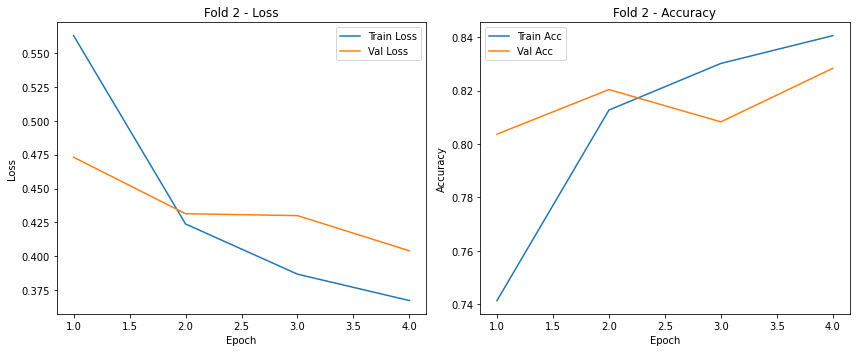

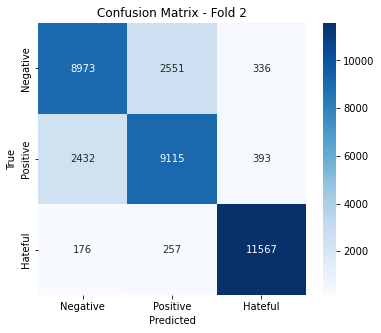


Training fold 3/5...
Epoch 1/4 - Train Loss: 0.5687 - Val Loss: 0.4778 - Train Acc: 0.7366 - Val Acc: 0.7968
Epoch 2/4 - Train Loss: 0.4265 - Val Loss: 0.4503 - Train Acc: 0.8108 - Val Acc: 0.8115
Epoch 3/4 - Train Loss: 0.3869 - Val Loss: 0.4337 - Train Acc: 0.8313 - Val Acc: 0.8085
Epoch 4/4 - Train Loss: 0.3666 - Val Loss: 0.4020 - Train Acc: 0.8405 - Val Acc: 0.8274


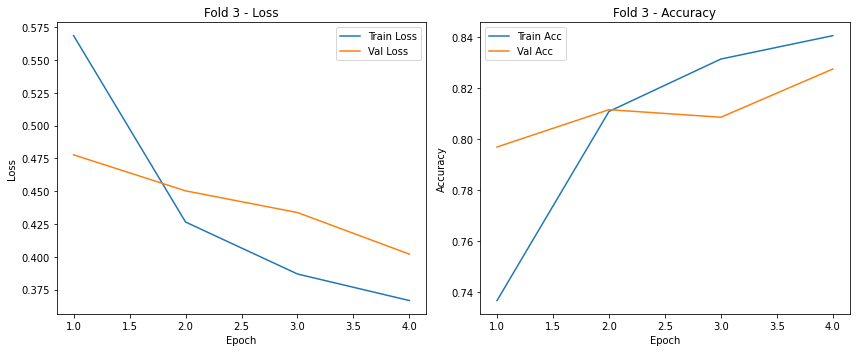

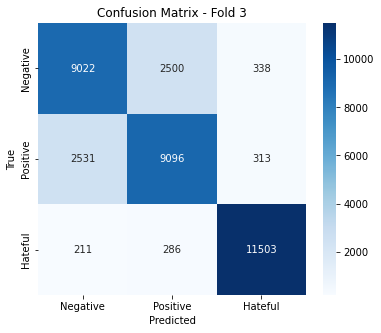


Training fold 4/5...
Epoch 1/4 - Train Loss: 0.5657 - Val Loss: 0.4738 - Train Acc: 0.7392 - Val Acc: 0.8011
Epoch 2/4 - Train Loss: 0.4269 - Val Loss: 0.4294 - Train Acc: 0.8105 - Val Acc: 0.8222
Epoch 3/4 - Train Loss: 0.3879 - Val Loss: 0.4169 - Train Acc: 0.8303 - Val Acc: 0.8251
Epoch 4/4 - Train Loss: 0.3686 - Val Loss: 0.4016 - Train Acc: 0.8400 - Val Acc: 0.8312


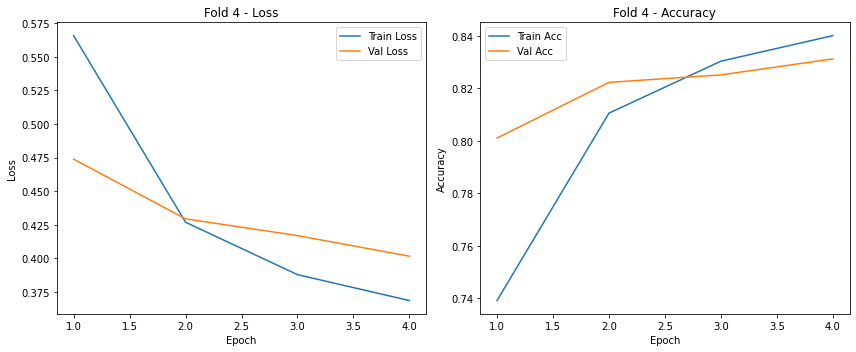

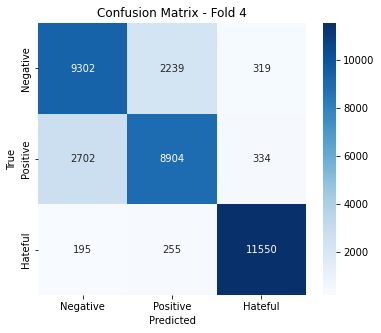


Training fold 5/5...
Epoch 1/4 - Train Loss: 0.5641 - Val Loss: 0.4767 - Train Acc: 0.7399 - Val Acc: 0.7983
Epoch 2/4 - Train Loss: 0.4252 - Val Loss: 0.4254 - Train Acc: 0.8124 - Val Acc: 0.8181
Epoch 3/4 - Train Loss: 0.3869 - Val Loss: 0.4079 - Train Acc: 0.8313 - Val Acc: 0.8264
Epoch 4/4 - Train Loss: 0.3693 - Val Loss: 0.4104 - Train Acc: 0.8405 - Val Acc: 0.8232


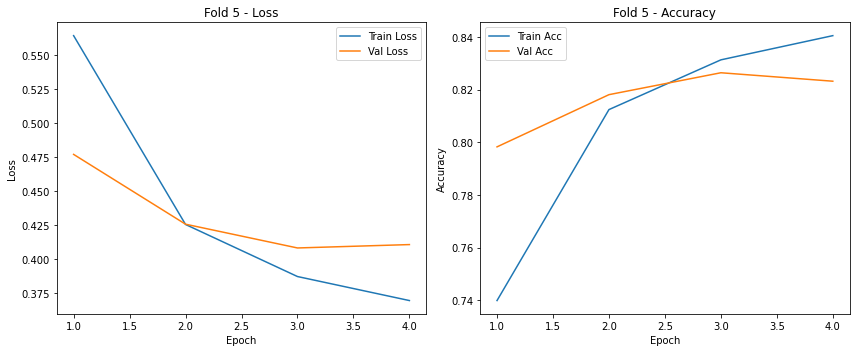

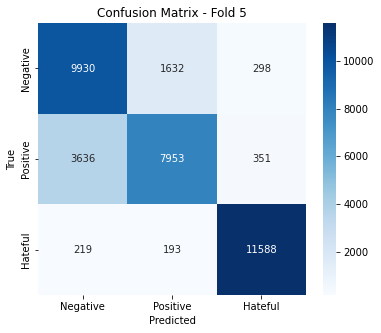

   fold  accuracy  precision    recall        f1
0     1  0.831480   0.832359  0.831480  0.830993
1     2  0.828352   0.826975  0.828352  0.827580
2     3  0.827402   0.826628  0.827402  0.826996
3     4  0.831173   0.830413  0.831173  0.830582
4     5  0.823212   0.827329  0.823212  0.821341


In [38]:
best_f1 = 0.0
best_cm = None
results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\nTraining fold {fold+1}/5...")

    train_texts, val_texts = X.iloc[train_idx], X.iloc[val_idx]
    train_labels, val_labels = y.iloc[train_idx], y.iloc[val_idx]

    train_dataset = TextDataset(train_texts.tolist(), train_labels.tolist())
    val_dataset = TextDataset(val_texts.tolist(), val_labels.tolist())
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False, collate_fn=collate_fn)

    model = TextCNN(vocab_size=len(vocab), embed_dim=100, num_classes=3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    model, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs=epochs_num
    )

    true_labels, pred_labels = evaluate_model(model, val_loader)

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    cm = confusion_matrix(true_labels, pred_labels)

    # Zapisanie wyników folda
    results.append({
        "fold": fold + 1,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm,
        "train_loss": train_loss_hist,
        "val_loss": val_loss_hist,
        "train_acc": train_acc_hist,
        "val_acc": val_acc_hist
    })

    # Zapis najlepszego modelu
    if fold == 0 or f1 > best_f1:
        best_f1 = f1
        best_cm = cm
        torch.save(model.state_dict(), f"best_model_fold_{fold+1}.pth")

    # Wykresy loss i accuracy
    epochs = range(1, len(train_loss_hist) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_hist, label='Train Loss')
    plt.plot(epochs, val_loss_hist, label='Val Loss')
    plt.title(f"Fold {fold+1} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_hist, label='Train Acc')
    plt.plot(epochs, val_acc_hist, label='Val Acc')
    plt.title(f"Fold {fold+1} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Macierz konfuzji
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negative", "Positive", "Hateful"],
                yticklabels=["Negative", "Positive", "Hateful"])
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Podsumowanie wyników
results_df = pd.DataFrame(results).drop(columns=["confusion_matrix", "train_loss", "val_loss", "train_acc", "val_acc"])
print(results_df)
